# Quantile Regression

This is the first notebook in a series on performing (deep) Bayesian quantile regression.

In this notebook we look into quantile regression and write two classes to perform quantile regression quickly. These classes are based on linear programming. In order to know how to set it up, we first need to understand the mathematical derivation to get to the optimal solution. As a consequence, we first will derive how to rewrite the quantile regression problem into a linear programming problem.

After all this is done, we will perform quantile regression for [homoscedastic](https://en.wikipedia.org/wiki/Heteroscedasticity) as well as [heteroscedastic](https://en.wikipedia.org/wiki/Heteroscedasticity) data.

First we make some necessary imports and build a `generate_data` function such that we can simply call it later on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
def generate_data(n_samples=100, x_min=0, x_max=3, intercept=1, slope=2, base_std=1.5, homoscedastic=True, extra_hetero_std=0.333, seed=42):
    np.random.seed(seed)
    x = np.linspace(x_min, x_max, n_samples)
    y_true = intercept + slope * x
    if homoscedastic:
        y = y_true + np.random.normal(loc=0, scale=base_std, size=n_samples)
    else:
        y = y_true + np.random.normal(loc=0, scale=base_std, size=n_samples)*x + np.random.normal(loc=0, scale=extra_hetero_std, size=n_samples)
    return x, y, y_true

## Rewriting the Quantile Regression into a linear programming problem

It is possible to rewrite the quantile regression loss function in a way that can easily be optimized. We will first derive this mathematically before coding everything. In case you are not necessarily interested in the mathematical details, you can just read the *summary* section to see what the solution is that we will code out.

Before diving into the mathematics below, it should be clear that any vector (e.g. $x$) is assumed to be a column vector. If it is a row vector it will be indicated by the transposed sign (e.g. $x^T$). All matrices will be indicated by a capital letter (e.g. $X$).

### Quantile Regression

The basic way that quantile regression works is that we set up a linear regression to estimate the true $y \in \mathbb{R}^n$ by:

$$ \hat{y} = X\theta$$

Where $X \in \mathbb{R}^{n\times p}$ is the data matrix, $\hat{y} \in \mathbb{R}^{n}$ the estimated output, and $\theta \in \mathbb{R}^p$ the parameters of the linear regression. The error term is defined as $\epsilon = y - \hat{y}$. The Quantile Loss function is then defined by:

$$ \mathcal{L}_Q(y, \hat{y}) =  \sum_{i=1}^{n} \rho_{\tau} (\underbrace{y_i - x_i^T \theta}_{\epsilon_i}) $$

The function $\rho_\tau (r) = r \cdot (\tau - I[r < 0])$, with $I[r<0]$ being the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) (I will not use the regular subscript notation, because I will need that later on for the identity matrix). Writing it out makes the loss function of the form

$$ \mathcal{L}_Q(y, \hat{y}) = \sum_{i=1}^{n} \tau |\epsilon_i| I[\epsilon_i \geq 0 ] + (1-\tau) |\epsilon_i| I[\epsilon_i < 0] $$

The loss function is also sometimes written in either of the following forms;

$$\begin{array}{rcl}
\mathcal{L}_Q(y, \hat{y}) &=& \tau \max(y-\hat{y},0) + (1-\tau) \left[- \min(y-\hat{y}, 0)\right] \\
\mathcal{L}_Q(y, \hat{y}) &=& \begin{cases}\tau (y-\hat{y}), & y-\hat{y} \leq 0 \\ (1-\tau) (y-\hat{y}), & y-\hat{y} < 0. \end{cases}
\end{array}
$$

They are all equivalent, but the method of using the $\rho_\tau(r)$ will make the derivation for linear programming easier to follow, so we will stick to that formulation for now. We find the optimum parameters $\theta$ by getting the arguments of minimizing the loss function.

$$ \hat{\theta} = \arg \min_{\theta} \mathcal{L}_Q(y, \hat{y}) = \arg \min_{\theta} \sum_{i=1}^{n} \tau |\epsilon_i| I[\epsilon_i \geq 0 ] + (1-\tau) |\epsilon_i| I[\epsilon_i < 0]. $$

In visual terms this is indicated by the fact that everything above all the data points above the regression line are weighted by $\tau$ in the loss function and everything underneath the regression line is weighted by $1-\tau$. This can be seen in the figure below.

<center>
<img src='img/quant_lossfunc.png' width="90%"></img>
</center>

### Linear Programming

There is a couple of ways to write an optimization problem. In terms of linear programming is this from time to time done by writing it as a [maximization problem](https://en.wikipedia.org/wiki/Linear_programming). It should be clear that it can quite quickly be rewritten as a minimization problem, because $\max_x f(x) = \min_x -f(x)$ (the same should be done with the boundary conditions). As a result, we will use the form

$$\begin{array}{crcl}
\min_z & c^T z, \\
\text{subject to} & Az & = &  b \\ 
&z & \geq & 0& 
\end{array}$$

This means we need to arrive somehow to this form. We are looking for a way to rewrite our quantile regression problem defined above into the matrix $A$ and the vectors $b, c, z$. Where I think it should be clear that the minimization should be equal for both terms. 

Since we have the condition that $z \geq 0$, and we will see that $\epsilon$ will end up in the $z$ vector, we will need a way to make sure that $\epsilon_i \geq 0, ~ \forall i$. A classic way of doing this is by decomposing $\epsilon_i \in \mathbb{R}$ is by splitting it up in an absolute manner $\epsilon_i = u_i - v_i$ where $u_i \in \mathbb{R}_+$ as well as $v_i \in \mathbb{R}_+$. If we remember that $\epsilon_i$ is the error of the estimate, a natural way to decompose this is by saying:

$$ \epsilon_i = u_i - v_i, ~ \text{for} ~ \begin{cases} u_i = \max(0, y-\hat{y}) \\ v_i = - \min(0, y-\hat{y}) \end{cases} $$

This allows us to rewrite the minimization problem as

$$ \min_\theta \sum_{i=1}^n \tau u_i + (1-\tau) v_i = \tau \underbrace{\begin{bmatrix}1 & 1 & \ldots & 1 \end{bmatrix}}_{\mathbf{1}_n^T} \begin{bmatrix} u_1 \\ u_2 \\ \vdots \\ u_n \end{bmatrix} + (1-\tau) \begin{bmatrix}1 & 1 & \ldots & 1 \end{bmatrix} \begin{bmatrix} v_1 \\ v_2 \\ \vdots \\ v_n \end{bmatrix}
= \tau \mathbf{1}_n^T u + (1-\tau) \mathbf{1}_n^T v$$

Where the residuals $\epsilon_i$ should satisfy the constraints $y_i - x_i^T \theta = \epsilon_i$. This is how we earlier defined the estimation error, but now it will appear in the constraints. As a result the total optimization problem can be defined as

$$\begin{array}{crcl}
\min_{\theta, u, v} & \tau \mathbf{1}_n^T u + (1-\tau) \mathbf{1}_n^T v, \\
\text{s.t.} & y_i & = &  x_i \theta + u_i - v_i, ~ i=1,\ldots,n 
\end{array}$$

where $\theta \in \mathbb{R}^p,~ u \in \mathbb{R}_+^n,~ v \in \mathbb{R}_+^n$. It is now clear that $theta, u, v$ are all elements of $z$. As we have seen earlier, we have to invoke $z \geq 0$. We know the $u$ and $v$ satisfy this condition, but $\theta$ does not. To make sure this is the case, we decompose $\theta$ in the same way as before; 

$$\theta = \theta^+ - \theta^-,~ \begin{cases} \theta^+ = \max(0, \theta) \\ \theta^- = - \min(0, \theta) \end{cases}$$. 

This allows us to rewrite the original equation $y = X\theta + \epsilon$ as $y=X(\theta^+ - \theta^-) + I_n u - I_n v$ (with $I_n$ being the $n\times n$ identity matrix). In order to rewrite this as the linear programming problem, we define $b$ and rewrite it as

$$\begin{array}{rcl} 
b:=y & = & X(\theta^+ - \theta^-) + I_n u + I_n v \\
&=& X \theta^+ - X \theta^- + I_n u - I_n v \\
\underbrace{y}_{b} &=& \underbrace{\begin{bmatrix} X & -X & I_n & -I_n \end{bmatrix}}_{A} \underbrace{ \begin{bmatrix}\theta^+ \\ \theta^- \\ u \\ v \end{bmatrix}}_{z}
\end{array}$$

As a result, we know have the constraint $Az=b$ and we satisfy $z \geq 0$. The last step is to find vector $c$. We know we should end up with $\min_z \tau \mathbf{1}_n^T u + (1-\tau) \mathbf{1}_n^T v$, but $z$ has the $theta^+, \theta^-$ terms which do not occur in the minimization problem. The easy way to make sure this works out all right is if we obtain

$$c^Tz = \mathbf{0}_p^T \theta^+ - \mathbf{0}_p^T  \theta^- + \tau \mathbf{1}_n^T u + (1-\tau) \mathbf{1}_n^T v,$$

where $\mathbf{0}_p^T = \begin{bmatrix} 0 & 0 & \ldots & 0 \end{bmatrix}$ with $\mathbf{0}_p \in \mathbb{R}^p$. This means we can define $c$ to be

$$c := \begin{bmatrix} \mathbf{0}_p \\ \mathbf{0}_p \\ \tau \mathbf{1}_n \\ (1-\tau) \mathbf{1}_n \end{bmatrix} = \begin{bmatrix} \mathbf{0}_{2p} \\ \tau \mathbf{1}_n \\ (1-\tau) \mathbf{1}_n \end{bmatrix}. $$

This can now all be solved by the classic methods of solving linear programming problems (for example [the simplex algorithm](https://en.wikipedia.org/wiki/Simplex_algorithm) or [the interior point method](https://en.wikipedia.org/wiki/Interior-point_method)). 

### Summary

To summarize quickly; we have written the quantile regression problem into a linear programming problem. The quantile regression problem was defined by estimating $y$ by the linear regression model $\hat{y} = X\theta$ subject to minimizing the loss function $\sum_{i=1}^{n} \tau |\epsilon_i| I[\epsilon_i \geq 0 ] + (1-\tau) |\epsilon_i| I[\epsilon_i < 0]$. 

It has been shown that this can be written in the form

$$\begin{array}{crcl}
\min_z & c^T z, \\
\text{subject to} & Az & = &  b \\ 
&z & \geq & 0& 
\end{array}$$

with

$$ \begin{array}{rclrcl}
A & = & \begin{bmatrix} X & -X & I_n & -I_n \end{bmatrix}, & b & = & \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} \\
c^T & = & \begin{bmatrix} \mathbf{0}_p ^T &\tau \mathbf{1}_n^T & (1-\tau) \mathbf{1}_n^T \end{bmatrix} ,& z & = & \begin{bmatrix}\theta^+ \\ \theta^- \\ u \\ v \end{bmatrix}
\end{array}$$

If we carefully look at the shapes of all the elements, we find that $A \in \mathbb{R}^{n\times(2p + 2n)}$, $b \in \mathbb{R}^n$, $c \in \mathbb{R}^{2p + 2n}$ and $z \in \mathbb{R}^{2p + 2n}$. The convex optimization problem can then quickly be solved by a classic convex optimization method.

## Coding a `QuantileRegressor`

Now that we know what vectors and matrices we need, we can make a `scikit-learn` based regressor to learn the parameters by calling a `fit` function and then predict an output using a `predict` function. We will do this for a single quantile and subsequently make a `MultiQuantileRegressor` which can do it for a range of quantiles, because often multiple quantiles are desired.

### Single regressor

For the single regressor the only input when setting it up is going to be what specified quantile we need. This is the $\tau$ (or `tau`) parameter. The rest will be calculated when calling the `fit` function. This requires an input/data matrix $X$ and an output matrix $y$. In general this will be the data coming from a train/test split. It is important that $y$ gets transformed to a column vector and $X$ gets cast in the proper form. In order to incorporate an intercept in the parameters, we need to add a column $\mathbf{1}_n$ before the other columns of $X$.

All that rests then is building matrix $A$ and the vectors $b$ and $c$. These are then passed to `scipy`'s `linprog` method (which is in the `optimize` sub-module). The output from this linear programming is of a type called `scipy.optimize.optimize.OptimizeResult`. It has some specific attributes, among which a `success` attribute which indicates if the optimization was succesful. 

In case it was succesful, the output is the $z$ vector. The first $p$ elements is $\theta^+$ and the second $p$ elements are $\theta^-$ elements (all non-negative). We just need to combine them to obtain $\theta = \theta^+ - \theta^-$. The array $\theta$ then contains all the necessary parameters to make predictions.

The `predict` function then just takes an array (vector or matrix) and makes prediction(s) for all the supplied data points.

In [3]:
class QuantileRegressor():
    def __init__(self, tau=0.5):
        self.tau = tau
        
    def fit(self, X, y):
        y = y.reshape(-1,1)
        if len(X.shape) == 1: #check if it is a 1d dataset and then recast it into a column vector
            X = X.reshape(-1,1)
        intercept = np.ones([X.shape[0], 1])
        X = np.hstack((intercept, X))
        n = X.shape[0]
        p = X.shape[1]
        A = np.hstack((X, -X, np.eye(n), -np.eye(n)))
        b = y.copy()
        c = np.vstack((
            np.zeros([p, 1]),
            np.zeros([p, 1]),
            self.tau * np.ones([n, 1]),
            (1-self.tau) * np.ones([n, 1])
        ))
        
        res = optimize.linprog(c, A_eq=A, b_eq=b, bounds=(0, None), method='interior-point')
        if res.success:
            theta_pos = res.x[0:p]
            theta_neg = res.x[p:2*p]
            self.theta = theta_pos - theta_neg
            self.intercept = self.theta[0]
            self.coef_ = self.theta[1:]
        else:
            raise ArithmeticError("The Linear Programming optimization was unsucessful.")
            
    def predict(self, X):
        if X.shape[0] == len(self.coef_): #check if this is a single sample
            X = X.reshape(1,-1)
        elif len(X.shape) == 1: #check if it is a 1d dataset and then recast it into a column vector
            X = X.reshape(-1,1)
        intercept = np.ones([X.shape[0], 1])
        X = np.hstack((intercept, X))
        y = np.dot(X, self.theta)
        return y
    

### Setting up a regressor for multiple quantiles

As mentioned earlier, it can easily be the case that we would like to perform multiple quantile regressions in a row for a range of quantiles. For this, we have made the `MultiQuantileRegressor`. It takes as an input either a list of $\tau$ values as input (`l_tau`), or just an integer `n_tau` ($n_\tau$) of the amount of $\tau$ values desired. This is then uniformly spaced over the (open) interval $\langle 0,1  \rangle$.

The `fit` function works in the same way as of the `QuantileRegressor`, but first sets up the arrays which stay fixed ($A$ and $b$) and then for every $\tau$ calls the function `_fit_single` where it sets up the array $c$ and performs the linear programming optimization. All the different parameters are then appended into one big $\theta$ matrix where $\theta \in \mathbb{R}^{p\times n_{\tau}}$ corresponding to the $\tau$ values which can be found in `l_tau`.

In [4]:
class MultiQuantileRegressor():
    def __init__(self, n_tau=None, l_tau=None):
        assert (l_tau != None) | (n_tau != None), "Please provide either `l_tau` or `n_tau`"
        if n_tau != None:
            self.l_tau = np.linspace(0, 1, n_tau+2)[1:-1]
            self.n_tau = n_tau
        else:
            self.l_tau = np.array(l_tau)
            self.n_tau = len(l_tau)
        
    def fit(self, X, y):
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        intercept = np.ones([X.shape[0], 1])
        X = np.hstack((intercept, X))
        n = X.shape[0]
        p = X.shape[1]
        A = np.hstack((X, -X, np.eye(n), -np.eye(n)))
        b = y.copy()
        
        self.theta = np.empty((self.n_tau, p))
        
        for i, tau in enumerate(self.l_tau):
            self.theta[i,:] = self._fit_single(A=A, b=b, n=n, p=p, tau=tau)
        
        self.n_coef = p-1
        self.intercept = self.theta[:,0]
        self.coef_ = self.theta[:,1:]
            
    def _fit_single(self, A, b, n, p, tau):
        c = np.vstack((
            np.zeros([2*p, 1]),
            tau * np.ones([n, 1]),
            (1-tau) * np.ones([n, 1])
        ))

        res = optimize.linprog(c, A_eq=A, b_eq=b, bounds=(0, None), method='interior-point')
        if res.success:
            theta_pos = res.x[0:p]
            theta_neg = res.x[p:2*p]
            theta = theta_pos - theta_neg
            return theta
        else:
            raise ArithmeticError(f"The Linear Programming optimization was unsucessful for tau = {tau}.")
        
    def predict(self, X):
        if X.shape[0] == self.n_coef:
            X = X.reshape(1,-1)
        elif len(X.shape) == 1:
            X = X.reshape(-1,1)
        intercept = np.ones([X.shape[0], 1])
        X = np.hstack((intercept, X))
        y = np.dot(X, self.theta.T)
        return y

## Fitting the `QuantRegressor` and `MultiQuantRegressor`

Now we are going fit the regressors on homoscedastic data first and subsequently on heteroscedastic data. For this we have made the `generate_data` function at the start of this notebook, where you can indicate homoscedasticity or not and can set the standard deviation if desired.

### Homoscedastic data

The homoscedastic data is generated by:

$$ y = 1 + 2x + \eta, ~~~ \eta \sim \mathcal{N}\left(0, \sigma^2\right), ~~~ \text{with } \sigma = \frac{3}{2}$$

In [5]:
x, y, y_true = generate_data(n_samples=250)

Let's see what the data looks like. There is also an `y_true` in the data which shows the original linear line where the noise was added on top of.

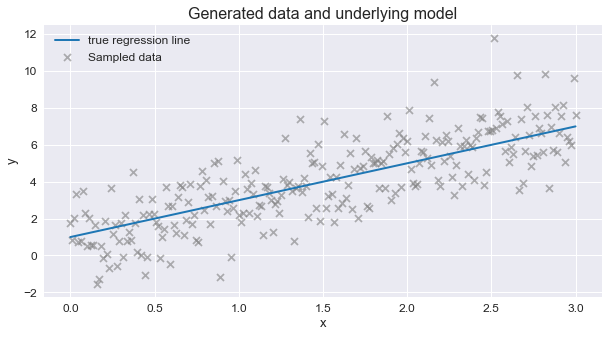

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(x, y, marker='x', label='Sampled data', color='tab:gray', alpha=0.6)
plt.plot(x, y_true, label='true regression line', lw=2, color='tab:blue')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Generated data and underlying model'); plt.legend()
plt.show()

Now we set up the `QuantileRegressor` and `MultiQuantileRegressor`, for a `tau=0.33` and `n_tau=5` respectively. We then simply call the `fit` functions and `predict` on the entire domain to make it available for the plot.

In [7]:
tau_s = 0.33
n_tau = 5
reg_single = QuantileRegressor(tau=tau_s)
reg_multi = MultiQuantileRegressor(n_tau=n_tau)

reg_single.fit(x, y)
reg_multi.fit(x, y)

x_fit = np.linspace(0, 3, 100).reshape(-1,1)

y_singlefit = reg_single.predict(x_fit)
y_multifit = reg_multi.predict(x_fit)

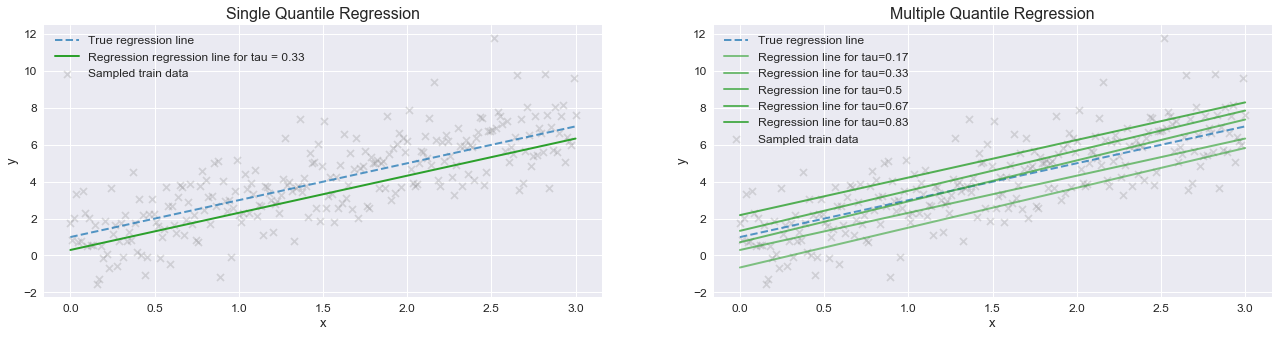

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))

ax[0].scatter(x, y, marker='x', label='Sampled train data', color='tab:gray', alpha=0.25)
ax[0].plot(x, y_true, label='True regression line', lw=2, ls='--', color='tab:blue', alpha=0.75)
ax[0].plot(x_fit, y_singlefit, label=f'Regression regression line for tau = {round(tau_s, 2)}', lw=2, ls='-', color='tab:green')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Single Quantile Regression')
ax[0].legend()

ax[1].set_title('Multiple Quantile Regression')
ax[1].scatter(x, y, marker='x', label='Sampled train data', color='tab:gray', alpha=0.25)
ax[1].plot(x, y_true, label='True regression line', lw=2, ls='--', color='tab:blue', alpha=0.75)
for i, tau in enumerate(reg_multi.l_tau):
    ax[1].plot(x_fit, y_multifit[:,i], label=f'Regression line for tau={round(tau, 2)}', lw=2, color='tab:green', alpha=(i+2*n_tau)/(3.5*n_tau))
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend()

plt.show()

### Heteroscedastic data

The heteroscedastic data is generated by:

$$ y = 1 + 10x + \eta_1 x + \eta_2, ~~~ \begin{cases} \eta_1 \sim \mathcal{N}\left(0, \sigma_1^2\right), & \text{with } \sigma_1 = 6 \\ \eta_2 \sim \mathcal{N}\left(0, \sigma_2^2\right), & \text{with } \sigma_2 = \frac{1}{3} \end{cases} $$

In [9]:
slope = 10
base_std = 6
x2, y2, y2_true = generate_data(n_samples=200, slope=slope, base_std=base_std, homoscedastic=False)

Let's see what the data looks like. There is also an `y_true` in the data which shows the original linear line where the noise was added on top of.

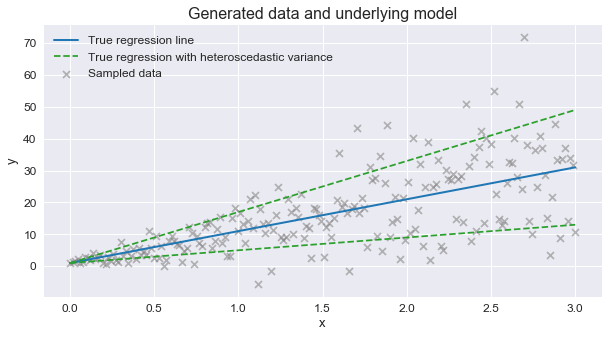

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(x2, y2, marker='x', label='Sampled data', color='tab:gray', alpha=0.55)
plt.plot(x2, y2_true, label='True regression line', lw=2, color='tab:blue')
plt.plot(x2, y2_true+base_std*x2, c='tab:green', ls='--', label='True regression with heteroscedastic variance')
plt.plot(x2, y2_true-base_std*x2, c='tab:green', ls='--')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Generated data and underlying model'); plt.legend()
plt.show()

In [11]:
tau2_s = 0.33
n_tau2 = 5
reg_single2 = QuantileRegressor(tau=tau_s)
reg_multi2 = MultiQuantileRegressor(n_tau=n_tau)

reg_single2.fit(x2, y2)
reg_multi2.fit(x2, y2)

x2_fit = np.linspace(0, 3, 100).reshape(-1,1)

y2_singlefit = reg_single2.predict(x2_fit)
y2_multifit = reg_multi2.predict(x2_fit)

Now we set up the `QuantileRegressor` and `MultiQuantileRegressor`, for a `tau=0.33` and `n_tau=5` respectively. We then simply call the `fit` functions and `predict` on the entire domain to make it available for the plot.

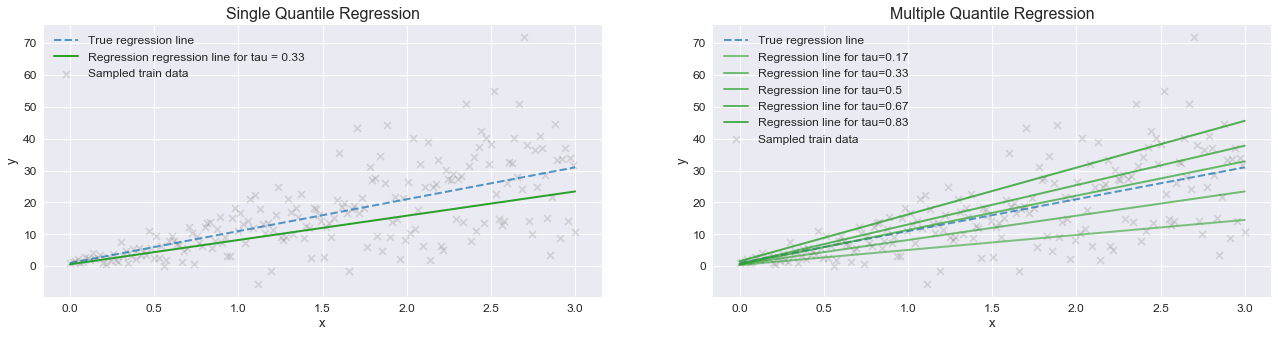

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(22,5))

ax[0].scatter(x2, y2, marker='x', label='Sampled train data', color='tab:grey', alpha=0.25)
ax[0].plot(x2, y2_true, label='True regression line', lw=2, ls='--', color='tab:blue', alpha=0.75)
ax[0].plot(x2_fit, y2_singlefit, label=f'Regression regression line for tau = {round(tau2_s, 2)}', lw=2, ls='-', color='tab:green')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Single Quantile Regression')
ax[0].legend()

ax[1].set_title('Multiple Quantile Regression')
ax[1].scatter(x2, y2, marker='x', label='Sampled train data', color='tab:grey', alpha=0.25)
ax[1].plot(x2, y2_true, label='True regression line', lw=2, ls='--', color='tab:blue', alpha=0.75)
for i, tau in enumerate(reg_multi2.l_tau):
    ax[1].plot(x2_fit, y2_multifit[:,i], label=f'Regression line for tau={round(tau, 2)}', lw=2, color='tab:green', alpha=(i+2*n_tau2)/(3.5*n_tau2))
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend()

plt.show()